In [1]:
# setting up spark, java and hadoop environments
import os
os.environ['SPARK_HOME'] = 'C:\spark\spark-3.2.0-bin-hadoop3.2'
os.environ['JAVA_HOME'] = 'C:\Program Files\Java\jdk1.8.0_301'
os.environ['HADOOP_HOME'] = 'C:\hadoop'

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql import DataFrameWriter
from textblob import TextBlob

In [4]:
def preprocessing(lines):
    #
    words = lines.select(explode(split(lines.value, "t_end")).alias("word"))
    
    # NaN values were removed
    words = words.na.replace('', None)
    words = words.na.drop()
    
    # below https, single characters, hashtags, RTs are removed from the tweets
    words = words.withColumn('word', F.regexp_replace('word', r'http\S+', ''))
    words = words.withColumn('word', F.regexp_replace('word', '@\w+', ''))
    words = words.withColumn('word', F.regexp_replace('word', '#', ''))
    words = words.withColumn('word', F.regexp_replace('word', 'RT', ''))
    words = words.withColumn('word', F.regexp_replace('word', ':', ''))
    return words

In [5]:
# text classification
def polarity_detection(text):
    return TextBlob(text).sentiment.polarity

def subjectivity_detection(text):
    return TextBlob(text).sentiment.subjectivity

def text_classification(words):
    # polarity detection
    polarity_detection_udf = udf(polarity_detection, StringType())
    words = words.withColumn("polarity", polarity_detection_udf("word"))
    # subjectivity detection
    subjectivity_detection_udf = udf(subjectivity_detection, StringType())
    words = words.withColumn("subjectivity", subjectivity_detection_udf("word"))
    return words

In [ ]:
if __name__ == "__main__":
    # create Spark session
    spark = SparkSession.builder.appName("TwitterSentimentAnalysis").getOrCreate()
    # read the tweet data from socket
    lines = spark.readStream.format("socket").option("host", "127.0.0.1").option("port", 5555).load()
    # Preprocess the data
    words = preprocessing(lines)
    # text classification to define polarity and subjectivity
    words = text_classification(words)
    words = words.repartition(1)
    query = words.writeStream.queryName("all_tweets")\
        .outputMode("append").format("parquet")\
        .option("path", "./parc")\
        .option("checkpointLocation", "./check")\
        .trigger(processingTime='60 seconds').start()
    query.awaitTermination()

In [8]:
!pip install pyarrow
!pip install fastparquet

  Created wheel for thrift: filename=thrift-0.15.0-py3-none-any.whl size=155944 sha256=0c00a65b2770015912749420bd96bd6949286e1c285449e74535568cd3e766a9
  Stored in directory: c:\users\natpe\appdata\local\pip\cache\wheels\4c\b5\5b\10af165d7e0895afdfe25ad487422ae8ada6ea422b0dc444ab
Successfully built thrift


In [3]:
from pathlib import Path
import pandas as pd

# the parquet files are read into a single dataframe for analysis
data_dir = Path('parc')
tweets_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)

In [4]:
tweets_df.head()

,word,polarity,subjectivity
0,Didn't look to see what it's about but gives m...,0.0,0.0
1,"Dad, if youâ€™re on Twitter and see this, em...",-0.15555555555555559,0.2888888888888889
2,"People, piss off with the vaccination push.",0.0,0.0
3,Myocarditis is a real risk after covid infec...,0.016666666666666663,0.4916666666666667
4,,0.0,0.0


In [19]:
tweets_df.dtypes

word             object
polarity         object
subjectivity     object
sentiment        object
neg             float64
neu             float64
pos             float64
compound        float64
dtype: object

In [5]:
tweets_df.info

<bound method DataFrame.info of                                                   word              polarity  \
0    Didn't look to see what it's about but gives m...                   0.0   
1      Dad, if youâ€™re on Twitter and see this, em...  -0.15555555555555559   
2          People, piss off with the vaccination push.                   0.0   
3      Myocarditis is a real risk after covid infec...  0.016666666666666663   
4                                                                        0.0   
..                                                 ...                   ...   
186    As an employer I make the promise not to imp...                   0.0   
187  25 him already! He is unfit. Unethical. And fl...              -0.03125   
188      1 vax doesn't work or even makes COVID worse                   -0.4   
189  Whoâ€™s told you itâ€™s only 2-3 weeks after v...                   0.0   
190                                Vaccination update                    0.0   

       

In [6]:
#Calculating Negative, Positive, Neutral and Compound values
from nltk.sentiment.vader import SentimentIntensityAnalyzer

for index, row in tweets_df['word'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    
    if neg > pos:
        tweets_df.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        tweets_df.loc[index, 'sentiment'] = "positive"
    else:
        tweets_df.loc[index, 'sentiment'] = "neutral"
        tweets_df.loc[index, 'neg'] = neg
        tweets_df.loc[index, 'neu'] = neu
        tweets_df.loc[index, 'pos'] = pos
        tweets_df.loc[index, 'compound'] = comp

tweets_df.head(10)

,word,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,Didn't look to see what it's about but gives m...,0.0,0.0,positive,0.0,0.0,0.0,0.0
1,"Dad, if youâ€™re on Twitter and see this, em...",-0.15555555555555559,0.2888888888888889,positive,0.0,1.0,0.0,0.0
2,"People, piss off with the vaccination push.",0.0,0.0,neutral,0.0,1.0,0.0,0.0
3,Myocarditis is a real risk after covid infec...,0.016666666666666663,0.4916666666666667,positive,0.0,1.0,0.0,0.0
4,,0.0,0.0,positive,0.0,1.0,0.0,0.0
5,"yahi tau paranoia hai, unko ho gya tau hume b...",0.26666666666666666,0.6333333333333333,neutral,0.0,1.0,0.0,0.0
6,". Follow, sign the declaration. Get behind o...",-0.4,0.7,positive,0.0,1.0,0.0,0.0
7,As an employer I make the promise not to imp...,0.0,0.0,neutral,0.0,1.0,0.0,0.0
8,If a 90% vaccination rate canâ€™t get uâ€¦,0.0,0.0,positive,0.0,1.0,0.0,0.0
9,Wouldn't mind some open border time to see f...,-0.048,0.528,neutral,0.0,1.0,0.0,0.0


In [7]:
tweets_df.tail()

,word,polarity,subjectivity,sentiment,neg,neu,pos,compound
186,As an employer I make the promise not to imp...,0.0,0.0,positive,0.15,0.701,0.15,0.0
187,25 him already! He is unfit. Unethical. And fl...,-0.03125,0.125,negative,0.00,1.000,0.00,0.0
188,1 vax doesn't work or even makes COVID worse,-0.4,0.6,negative,NaN,NaN,NaN,NaN
189,Whoâ€™s told you itâ€™s only 2-3 weeks after v...,0.0,1.0,neutral,0.00,1.000,0.00,0.0
190,Vaccination update,0.0,0.0,neutral,0.00,1.000,0.00,0.0


In [8]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

#Count_values for sentiment
count_values_in_column(tweets_df,"sentiment")

,Total,Percentage
neutral,9757,43.57
positive,7307,32.63
negative,5330,23.80


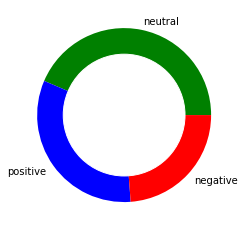

In [9]:
from matplotlib import pyplot as plt
# create data for Pie Chart
pichart = count_values_in_column(tweets_df,"sentiment")
names= pichart.index
size=pichart["Percentage"]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [10]:
#Function to Create Wordcloud
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

def create_wordcloud(text):
    #mask = np.array(Image.open("cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
                   mask = None,
                   max_words=3000,
                   stopwords=stopwords,
                   repeat=True)
    wc.generate(str(text))
    wc.to_file("wc.png")
    
    print("Word Cloud Saved Successfully")
    
    path="wc.png"
    display(Image.open(path))

In [20]:
tweets_df['subjectivity'] = tweets_df['subjectivity'].astype(float, errors = 'raise')

Word Cloud Saved Successfully


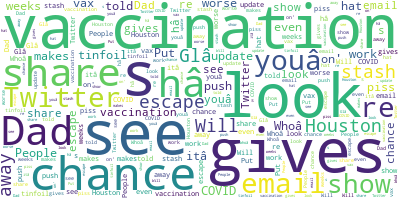

In [11]:
#Creating wordcloud for all tweets
create_wordcloud(tweets_df["word"].values)

Average people subjectivity for positive tweets:  0.22473967094139652
Word Cloud Saved Successfully


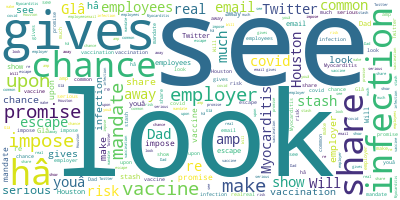

In [23]:
#Creating wordcloud for positive tweets
positive_tweets = tweets_df[tweets_df['sentiment']=='positive']
print('Average people subjectivity for positive tweets: ', positive_tweets['subjectivity'].mean())
create_wordcloud(positive_tweets["word"].values)

Average people subjectivity for negative tweets:  0.21515128869299172
Word Cloud Saved Successfully


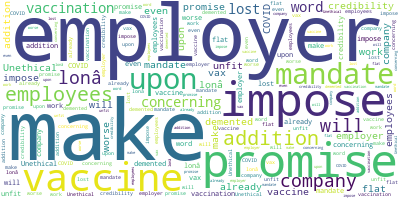

In [22]:
#Creating wordcloud for negative tweets
negative_tweets = tweets_df[tweets_df['sentiment']=='negative']
print('Average people subjectivity for negative tweets: ', negative_tweets['subjectivity'].mean())
create_wordcloud(negative_tweets["word"].values)

Average people subjectivity:  0.2171856325845153
Word Cloud Saved Successfully


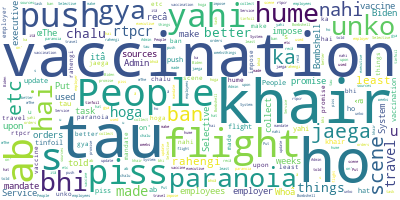

In [21]:
#Creating wordcloud for neutral tweets
neutral_tweets = tweets_df[tweets_df['sentiment']=='neutral']
print('Average people subjectivity: ', neutral_tweets['subjectivity'].mean())
create_wordcloud(neutral_tweets["word"].values)

In [21]:
#Calculating tweet’s lenght and word count
tweets_df['text_len'] = tweets_df['word'].astype(str).apply(len)
tweets_df['text_word_count'] = tweets_df['word'].apply(lambda x: len(str(x).split()))
round(pd.DataFrame(tweets_df.groupby("sentiment").text_len.mean()),2)

,text_len
sentiment,
negative,86.52
neutral,87.15
positive,87.91


In [22]:
round(pd.DataFrame(tweets_df.groupby("sentiment").text_word_count.mean()),2)

,text_word_count
sentiment,
negative,14.13
neutral,14.21
positive,14.32


In [27]:
import string
import re
import nltk 

#Removing Punctuation
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0–9]+', '', text)
    return text

tweets_df['punct'] = tweets_df['word'].apply(lambda x: remove_punct(x))

#Appliyng tokenization
def tokenization(text):
    text = re.split('\W+', text)
    return text

tweets_df['tokenized'] = tweets_df['punct'].apply(lambda x: tokenization(x.lower()))

#Removing stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
tweets_df['nonstop'] = tweets_df['tokenized'].apply(lambda x: remove_stopwords(x))

#Appliyng Stemmer
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

tweets_df['stemmed'] = tweets_df['nonstop'].apply(lambda x: stemming(x))

#Cleaning Text
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text

tweets_df.head()

,word,polarity,subjectivity,sentiment,neg,neu,pos,compound,text_len,text_word_count,punct,tokenized,nonstop,stemmed
0,Didn't look to see what it's about but gives m...,0.0,0.0,positive,0.0,0.0,0.0,0.0,84,19,Didnt look to see what its about but gives me ...,"[didnt, look, to, see, what, its, about, but, ...","[didnt, look, see, gives, chance, share, hâ, ]","[didnt, look, see, give, chanc, share, hâ, ]"
1,"Dad, if youâ€™re on Twitter and see this, em...",-0.15555555555555559,0.2888888888888889,positive,0.0,1.0,0.0,0.0,128,25,Dad if youâ€™re on Twitter and see this emai...,"[, dad, if, youâ, re, on, twitter, and, see, t...","[, dad, youâ, twitter, see, email, show, escap...","[, dad, youâ, twitter, see, email, show, escap..."
2,"People, piss off with the vaccination push.",0.0,0.0,neutral,0.0,1.0,0.0,0.0,44,7,People piss off with the vaccination push,"[, people, piss, off, with, the, vaccination, ...","[, people, piss, vaccination, push]","[, peopl, piss, vaccin, push]"
3,Myocarditis is a real risk after covid infec...,0.016666666666666663,0.4916666666666667,positive,0.0,1.0,0.0,0.0,122,18,Myocarditis is a real risk after covid infec...,"[, myocarditis, is, a, real, risk, after, covi...","[, myocarditis, real, risk, covid, infection, ...","[, myocard, real, risk, covid, infect, much, c..."
4,,0.0,0.0,positive,0.0,1.0,0.0,0.0,0,0,,[],[],[]


In [29]:
from sklearn.feature_extraction.text import CountVectorizer

#Appliyng Countvectorizer
countVectorizer = CountVectorizer(analyzer=clean_text) 
countVector = countVectorizer.fit_transform(tweets_df['word'])
print('{} Number of reviews has {} words'.format(countVector.shape[0], countVector.shape[1]))
#print(countVectorizer.get_feature_names())

count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())
count_vect_df.head()

22394 Number of reviews has 10050 words


,,aaron,ab,abandon,abc,abet,abf,abhealth,abhorr,abid,...,šâ,šðÿ,ž,žstudiesâ,žð,žðÿ,ƒ,ƒðÿ,ˆ,ˆðÿ
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# Most Used Words
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0,ascending=False).head(20)
countdf[1:11]

,0
vaccin,9495
â,2949
covid,2488
use,1710
biden,1677
system,1574
servic,1536
order,1500
select,1476
admin,1461


In [31]:
#Function to ngram
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#n2_bigram
n2_bigrams = get_top_n_gram(tweets_df['word'],(2,2),20)
n2_bigrams

[('biden admin', 1457),
 ('selective service', 1446),
 ('admin used', 1443),
 ('used executive', 1443),
 ('executive orders', 1443),
 ('bombshell sources', 1415),
 ('sources œthe', 1415),
 ('œthe biden', 1415),
 ('orders task', 1415),
 ('task selective', 1415),
 ('service collect', 1415),
 ('collect recâ', 1415),
 ('covid 19', 859),
 ('vaccine mandate', 677),
 ('mandate employees', 635),
 ('employer make', 633),
 ('make promise', 633),
 ('promise impose', 633),
 ('impose vaccine', 633),
 ('addition company', 633)]

In [32]:
#n3_trigram
n3_trigrams = get_top_n_gram(tweets_df['word'],(3,3),20)
n3_trigrams

[('biden admin used', 1443),
 ('admin used executive', 1443),
 ('used executive orders', 1443),
 ('bombshell sources œthe', 1415),
 ('sources œthe biden', 1415),
 ('œthe biden admin', 1415),
 ('executive orders task', 1415),
 ('orders task selective', 1415),
 ('task selective service', 1415),
 ('selective service collect', 1415),
 ('service collect recâ', 1415),
 ('vaccine mandate employees', 635),
 ('employer make promise', 633),
 ('make promise impose', 633),
 ('promise impose vaccine', 633),
 ('impose vaccine mandate', 633),
 ('addition company lonâ', 633),
 ('covid 19 vaccination', 416),
 ('royal courts justice', 334),
 ('hearing child vaccination', 286)]